In [1]:
import pandas as pd
import os 
import numpy as np
import scipy as sp
import scipy.stats as stats
import Bio
import rpy2
%load_ext rpy2.ipython

In [12]:
%%R

###
library(SingleCellExperiment)
library(scater)
library(SC3)
options(stringsAsFactors = FALSE)
library(gridExtra)
library(grid)
library(stringr)
library(scImpute)
library(SummarizedExperiment)
###readin1
scdata <- readRDS("scImpute_all_k55/parental_removed.rds")
#####export data for formatting in python, because R sucks majorly
write.table(counts(scdata),file='tmp_counts.csv',sep=',')

In [48]:
#########format in python
###readin
M_P_all = pd.read_csv('avg_values/M_P_all.csv',sep=',',index_col=0)
M_P_all.columns = ['counts']
###readin
counts_scdata = pd.read_csv('tmp_counts.csv',sep=',')
###format and sort
counts_scdata_cols = list(counts_scdata.columns)
M_P_all.sort_values(by=list(counts_scdata.index),axis=1)
counts_scdata = counts_scdata.merge(M_P_all,how='inner',left_index=True,right_index=True)
log2fc = counts_scdata.copy()
###
for cell in counts_scdata_cols:
    log2fc[cell] = np.log2(counts_scdata[cell]/counts_scdata['counts'])
log2fc.tail()

/home/johnny/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log2
  


,AAACCTGCAACGATCT-1,AAACCTGGTAAAGTCA-1,AAACCTGGTAGCTAAA-1,AAACGGGAGTTAACGA-1,AAACGGGAGTTGAGTA-1,AAACGGGCAGATGGCA-1,AAACGGGGTCGACTAT-1,AAACGGGGTGTTGAGG-1,AAACGGGGTTGCGTTA-1,AAACGGGTCTGTCAAG-1,...,TTTGGTTTCCTAGGGC-1,TTTGTCAAGAAGAAGC-1,TTTGTCAAGACCACGA-1,TTTGTCAAGTACTTGC-1,TTTGTCACAAATCCGT-1,TTTGTCACATGCAATC-1,TTTGTCAGTAAATGAC-1,TTTGTCAGTTCGCTAA-1,TTTGTCATCTGTCTAT-1,counts
ENSG00000276256,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,0.030784
ENSG00000273748,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-inf,-inf,-inf,-inf,-2.212205,-inf,-2.212205,-inf,-inf,0.046338
ENSG00000278817,-inf,-inf,-inf,2.784167,-inf,-inf,-inf,-inf,-inf,-inf,...,-1.859689,-3.859689,-2.274726,-1.537761,0.310236,-0.689764,0.840751,-0.859689,-0.689764,0.145172
ENSG00000278384,4.029280,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-2.614576,-2.614576,-2.614576,-2.614576,-2.614576,-2.614576,-2.614576,-inf,-inf,0.061244
ENSG00000271254,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-1.478599,-2.478599,-2.478599,-1.478599,-2.478599,-2.478599,-1.478599,-2.478599,-2.478599,0.055736


In [61]:
##########continue formatting in python, because R sucks
##########import cluster identities
LVM2 = []
for i in range(5):
    filenum = i+1
    LVM2.append(pd.read_csv('HG_Rcode_FC_KM/M_LVM2_'+str(filenum)+'.txt.csv',sep=',',index_col=0))
#########calculate correlations ; spearman rank
LVM2_corr = []
for i in range(5):
    tmp_corrmatrix = []
    for cell in counts_scdata_cols:
        test_df = LVM2[i].copy()
        test_df = test_df.merge(pd.DataFrame(log2fc[cell]),how='inner',left_index=True,right_index=True)
        tmp_corrmatrix.append(stats.spearmanr(test_df)[0])
    LVM2_corr.append(tmp_corrmatrix)
####

In [84]:
#################save files
for i in range(5):
    filenum = i+1
    filename = 'spearman_cells_correlation/LVM2_'+str(filenum)+'_spearman.txt'
    thefile = open(filename, 'w')
    print >> thefile, "spearmanr"
    print(i,filenum,filename)
    for item in LVM2_corr[i]:
        print>>thefile, item
    thefile.close()

(0, 1, 'spearman_cells_correlation/LVM2_1_spearman.txt')
(1, 2, 'spearman_cells_correlation/LVM2_2_spearman.txt')
(2, 3, 'spearman_cells_correlation/LVM2_3_spearman.txt')
(3, 4, 'spearman_cells_correlation/LVM2_4_spearman.txt')
(4, 5, 'spearman_cells_correlation/LVM2_5_spearman.txt')


In [110]:
%%R

###########back in R
##########assign correlation matrices generated in python to scdata object
###import data
LVM2_1 <- as.vector(data.matrix(read.csv('spearman_cells_correlation/LVM2_1_spearman.txt',sep='\t')))
LVM2_2 <- as.vector(data.matrix(read.csv('spearman_cells_correlation/LVM2_2_spearman.txt',sep='\t')))
LVM2_3 <- as.vector(data.matrix(read.csv('spearman_cells_correlation/LVM2_3_spearman.txt',sep='\t')))
LVM2_4 <- as.vector(data.matrix(read.csv('spearman_cells_correlation/LVM2_4_spearman.txt',sep='\t')))
LVM2_5 <- as.vector(data.matrix(read.csv('spearman_cells_correlation/LVM2_5_spearman.txt',sep='\t')))
###
colData(scdata)$LVM2_1_corr <- LVM2_1
colData(scdata)$LVM2_2_corr <- LVM2_2
colData(scdata)$LVM2_3_corr <- LVM2_3
colData(scdata)$LVM2_4_corr <- LVM2_4
colData(scdata)$LVM2_5_corr <- LVM2_5
###
colData(scdata)

DataFrame with 7356 rows and 8 columns
                            Sample_ID    Study_ID    Celltype  LVM2_1_corr
                          <character> <character> <character>    <numeric>
AAACCTGCAACGATCT-1 AAACCTGCAACGATCT-1           P         P_1  0.107035883
AAACCTGGTAAAGTCA-1 AAACCTGGTAAAGTCA-1           P         P_2  0.054129889
AAACCTGGTAGCTAAA-1 AAACCTGGTAGCTAAA-1           P         P_3  0.025851079
AAACGGGAGTTAACGA-1 AAACGGGAGTTAACGA-1           P         P_4  0.047407574
AAACGGGAGTTGAGTA-1 AAACGGGAGTTGAGTA-1           P         P_5 -0.001721205
...                               ...         ...         ...          ...
TTTGTCACAAATCCGT-1 TTTGTCACAAATCCGT-1        LVM2      LVM2_2    0.3200898
TTTGTCACATGCAATC-1 TTTGTCACATGCAATC-1        LVM2      LVM2_3    0.3166463
TTTGTCAGTAAATGAC-1 TTTGTCAGTAAATGAC-1        LVM2      LVM2_2    0.3477867
TTTGTCAGTTCGCTAA-1 TTTGTCAGTTCGCTAA-1        LVM2      LVM2_2    0.3248869
TTTGTCATCTGTCTAT-1 TTTGTCATCTGTCTAT-1        LVM2      LVM2_3

## Plot
### plot all (P,LVM1,LVM2) first

In [170]:
%%R

size_var = 1.3

In [188]:
%%R
###plot TSNE
plotTSNE(
    scdata,
    colour_by = "Study_ID"
)
ggsave("figures/by_origin_2.pdf")

In [183]:
%%R
##########plot LVM2_1_corr
#####read in TSNE calculated data
TSNE <- data.frame(reducedDim(scdata, "TSNE"))
####add in sample data
TSNE$corr <- colData(scdata)$LVM2_1_corr
####
ggplot(TSNE, aes(X1, X2))+ 
geom_point(mapping = aes(color = corr),size = size_var) + 
scale_colour_gradient2(low = "blue", mid = "yellow", high = "red",midpoint=median(TSNE$corr))
ggsave("figures/corr_LVM2_1.pdf")

In [184]:
%%R
##########plot LVM2_2_corr
#####read in TSNE calculated data
TSNE <- data.frame(reducedDim(scdata, "TSNE"))
####add in sample data
TSNE$corr <- colData(scdata)$LVM2_2_corr
####
ggplot(TSNE, aes(X1, X2))+ 
geom_point(mapping = aes(color = corr),size = size_var) + 
scale_colour_gradient2(low = "blue", mid = "yellow", high = "red",midpoint=median(TSNE$corr))
ggsave("figures/corr_LVM2_2.pdf")

In [185]:
%%R
##########plot LVM2_3_corr
#####read in TSNE calculated data
TSNE <- data.frame(reducedDim(scdata, "TSNE"))
####add in sample data
TSNE$corr <- colData(scdata)$LVM2_3_corr
####
ggplot(TSNE, aes(X1, X2))+ 
geom_point(mapping = aes(color = corr),size = size_var) + 
scale_colour_gradient2(low = "blue", mid = "yellow", high = "red",midpoint=median(TSNE$corr))
ggsave("figures/corr_LVM2_3.pdf")

In [186]:
%%R
##########plot LVM2_4_corr
#####read in TSNE calculated data
TSNE <- data.frame(reducedDim(scdata, "TSNE"))
####add in sample data
TSNE$corr <- colData(scdata)$LVM2_4_corr
####
ggplot(TSNE, aes(X1, X2))+ 
geom_point(mapping = aes(color = corr),size = size_var) + 
scale_colour_gradient2(low = "blue", mid = "yellow", high = "red",midpoint=median(TSNE$corr))
ggsave("figures/corr_LVM2_4.pdf")

In [187]:
%%R
##########plot LVM2_5_corr
#####read in TSNE calculated data
TSNE <- data.frame(reducedDim(scdata, "TSNE"))
####add in sample data
TSNE$corr <- colData(scdata)$LVM2_5_corr
####
ggplot(TSNE, aes(X1, X2))+ 
geom_point(mapping = aes(color = corr),size = size_var) + 
scale_colour_gradient2(low = "blue", mid = "yellow", high = "red",midpoint=median(TSNE$corr))
ggsave("figures/corr_LVM2_5.pdf")

## Plot
### plot P only

In [176]:
%%R
####pull out only those are parental
scdata_Ponly <- scdata[ , colData(scdata)$Study_ID == "P"]

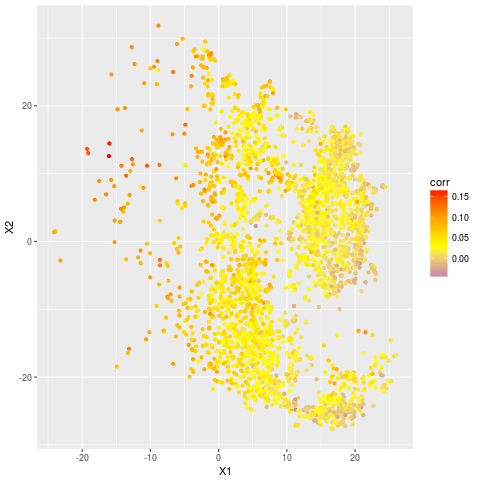

In [177]:
%%R
##########plot LVM2_1_corr
#####read in TSNE calculated data
TSNE <- data.frame(reducedDim(scdata_Ponly, "TSNE"))
####add in sample data
TSNE$corr <- colData(scdata_Ponly)$LVM2_1_corr
####
ggplot(TSNE, aes(X1, X2))+ 
geom_point(mapping = aes(color = corr),size = size_var) + 
scale_colour_gradient2(low = "blue", mid = "yellow", high = "red",midpoint=median(TSNE$corr))


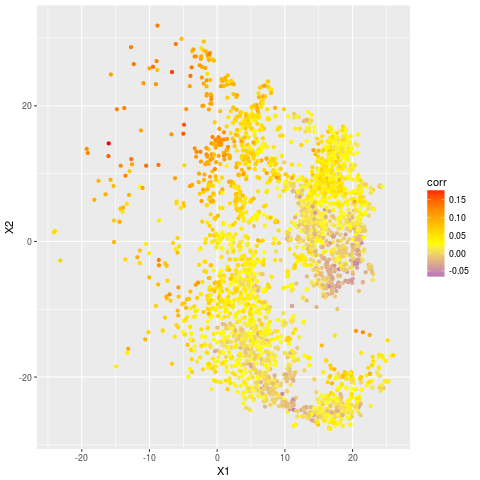

In [178]:
%%R
##########plot LVM2_2_corr
#####read in TSNE calculated data
TSNE <- data.frame(reducedDim(scdata_Ponly, "TSNE"))
####add in sample data
TSNE$corr <- colData(scdata_Ponly)$LVM2_2_corr
####
ggplot(TSNE, aes(X1, X2))+ 
geom_point(mapping = aes(color = corr),size = size_var) + 
scale_colour_gradient2(low = "blue", mid = "yellow", high = "red",midpoint=median(TSNE$corr))


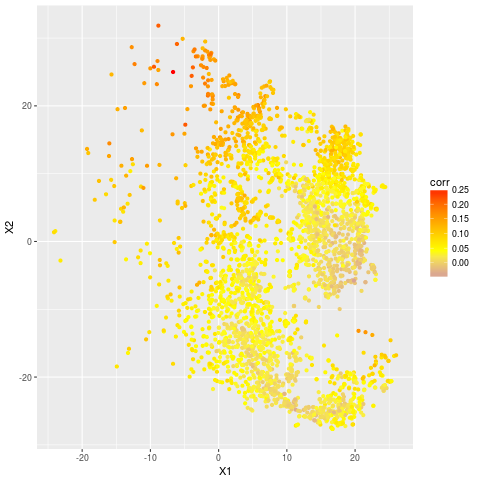

In [179]:
%%R
##########plot LVM2_3_corr
#####read in TSNE calculated data
TSNE <- data.frame(reducedDim(scdata_Ponly, "TSNE"))
####add in sample data
TSNE$corr <- colData(scdata_Ponly)$LVM2_3_corr
####
ggplot(TSNE, aes(X1, X2))+ 
geom_point(mapping = aes(color = corr),size = size_var) + 
scale_colour_gradient2(low = "blue", mid = "yellow", high = "red",midpoint=median(TSNE$corr))


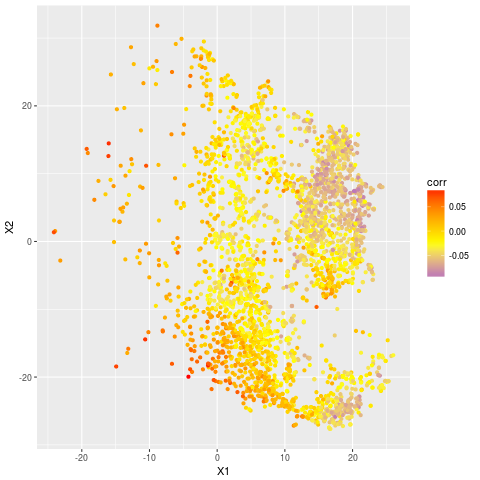

In [180]:
%%R
##########plot LVM2_4_corr
#####read in TSNE calculated data
TSNE <- data.frame(reducedDim(scdata_Ponly, "TSNE"))
####add in sample data
TSNE$corr <- colData(scdata_Ponly)$LVM2_4_corr
####
ggplot(TSNE, aes(X1, X2))+ 
geom_point(mapping = aes(color = corr),size = size_var) + 
scale_colour_gradient2(low = "blue", mid = "yellow", high = "red",midpoint=median(TSNE$corr))


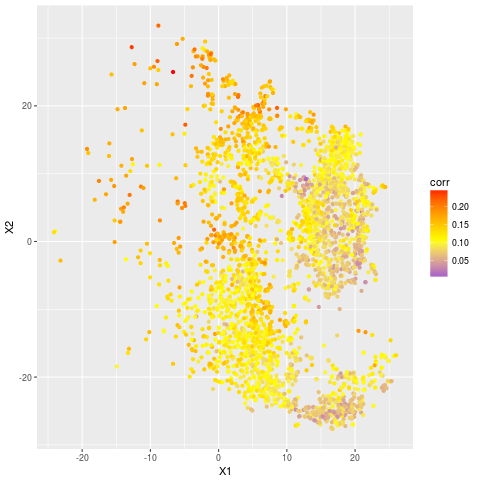

In [181]:
%%R
##########plot LVM2_5_corr
#####read in TSNE calculated data
TSNE <- data.frame(reducedDim(scdata_Ponly, "TSNE"))
####add in sample data
TSNE$corr <- colData(scdata_Ponly)$LVM2_5_corr
####
ggplot(TSNE, aes(X1, X2))+ 
geom_point(mapping = aes(color = corr),size = size_var) + 
scale_colour_gradient2(low = "blue", mid = "yellow", high = "red",midpoint=median(TSNE$corr))


In [153]:
# %%R
# #####import logfc data of averages of clusters 
# LVM2_1 <- read.csv('HG_Rcode_FC_KM/M_LVM2_1.txt.csv',sep=',')
# LVM2_2 <- read.csv('HG_Rcode_FC_KM/M_LVM2_2.txt.csv',sep=',')
# LVM2_3 <- read.csv('HG_Rcode_FC_KM/M_LVM2_3.txt.csv',sep=',')
# LVM2_4 <- read.csv('HG_Rcode_FC_KM/M_LVM2_4.txt.csv',sep=',')
# LVM2_5 <- read.csv('HG_Rcode_FC_KM/M_LVM2_5.txt.csv',sep=',')
# #####import average value of all parental cells
# M_P_all <- read.csv('avg_values/M_P_all.csv',sep=',')
# colnames(M_P_all) <- c('gene','counts')
# M_P_all

In [11]:
# %%R

##############R SUCKS SO MUCH BALLS!!!!!!!!!!!

# #####calc log2fc for each cell
# ###
# log2fc = function(counts,M_P_all){
#     counts <- matrix(counts)
#     ####sort to match order of M_P_all
#     target <- rownames(counts)
#     M_P_all <- M_P_all[match(target, M_P_all$gene),]
#     M_P_all
#     ####get column list
#     counts_cols <- colnames(counts)
#     ####calc
#     M_P_all <- subset(M_P_all, select = c(counts))
#     counts <- cbind(counts,M_P_all)
#     for (cell in c("AAACCTGCAACGATCT-1")){
#         counts <- counts[,"AAACCTGCAACGATCT-1"]/counts$counts
#         print(length(counts[,cell]))
#         print(colnames(counts))
#         print(length(counts[,'counts']))
#     }
#     ####return
# #     return(counts)
# }
# ###
# # assays(scdata)$log2fc <- log2fc(counts(scdata),M_P_all)

# log2fc(counts(scdata),M_P_all)


Error in data.frame(..., check.names = FALSE) : 
  arguments imply differing number of rows: 97915716, 0


/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in data.frame(..., check.names = FALSE) : 
  arguments imply differing number of rows: 97915716, 0

  warnings.warn(x, RRuntimeWarning)


In [77]:
# %%R

# counts <- counts(scdata)
# counts <- counts[order(row.names(counts)),]
# counts <- cbind(counts,M_P_all)
# test <- colnames(counts)

In [78]:
# %%R
# for (item in test) {
#     print(item)
#     print('okay')
# }

[1] "AAACCTGCAACGATCT-1"
[1] "okay"
[1] "AAACCTGGTAAAGTCA-1"
[1] "okay"
[1] "AAACCTGGTAGCTAAA-1"
[1] "okay"
[1] "AAACGGGAGTTAACGA-1"
[1] "okay"
[1] "AAACGGGAGTTGAGTA-1"
[1] "okay"
[1] "AAACGGGCAGATGGCA-1"
[1] "okay"
[1] "AAACGGGGTCGACTAT-1"
[1] "okay"
[1] "AAACGGGGTGTTGAGG-1"
[1] "okay"
[1] "AAACGGGGTTGCGTTA-1"
[1] "okay"
[1] "AAACGGGTCTGTCAAG-1"
[1] "okay"
[1] "AAAGATGAGGCATGTG-1"
[1] "okay"
[1] "AAAGATGTCGTCTGCT-1"
[1] "okay"
[1] "AAAGATGTCTAACTCT-1"
[1] "okay"
[1] "AAAGATGTCTGTCCGT-1"
[1] "okay"
[1] "AAAGCAAAGTGCGATG-1"
[1] "okay"
[1] "AAAGCAACAAGAGTCG-1"
[1] "okay"
[1] "AAAGCAACAGTAGAGC-1"
[1] "okay"
[1] "AAAGCAATCCACGACG-1"
[1] "okay"
[1] "AAAGTAGAGGGTCGAT-1"
[1] "okay"
[1] "AAAGTAGCAAGCCGTC-1"
[1] "okay"
[1] "AAAGTAGCATCATCCC-1"
[1] "okay"
[1] "AAAGTAGGTCCATGAT-1"
[1] "okay"
[1] "AAAGTAGGTCTGATCA-1"
[1] "okay"
[1] "AAAGTAGGTGGACGAT-1"
[1] "okay"
[1] "AAATGCCAGTCCCACG-1"
[1] "okay"
[1] "AAATGCCAGTTGCAGG-1"
[1] "okay"
[1] "AAATGCCCAGTGGGAT-1"
[1] "okay"
[1] "AAATGCCGTCGTTGTA-1"
[1]

In [56]:
# %%R
# tail(M_P_all)

                    counts
ENSG00000282057 0.02138691
ENSG00000282386 0.06286455
ENSG00000282851 0.05897602
ENSG00000282988 0.07096565
ENSG00000283013 0.03208036
ENSG00000283103 1.05865198
